<a href="https://colab.research.google.com/github/imiolczy/additionalDataSourcesTest/blob/main/DeepDiversProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data - The Deep Divers

The follwoing project is provided by

*   Simon Kopold - XXXXXX
*   Jurica Pejic - 323024
*   Tobias Imiolczyk - 316030

and deals with an data-driven pricing strategy for a fuel station in the context of 4P. 



Offene Punkte: 

*   Welcher Zeitraum für Öl und Wechselkurs Daten? --> Analysezeitraum: 3Q 2014 (01.07.2014) bis 1Q 2021 (31.03.2021)
*   Wie genau sollen Basisdatensätze beschrieben werden?

*   Theorie Grundlage zu 4P? --> Ja aber ohne große Quellen
*   Seit 2021: Zustäzliche CO2 Steuer auf Sprit --> Theorie erwünscht? (kann ich aus meiner Bachelorthesis ziehen) --> gut

*   Datenstruktur über github anlegen und downloadbar machen (Simon)
*   Platzhalter




# Theoretical Background


Before we perform a data-driven analysis we will focus on some theoretical background to form a basis for our analysis.


**The 4P's**

... siehe unten


**New CO2 tax in Germany**

Since 2021, a new law came into force in Germany, which includes an additional tax on CO2 emissions, resulting in an increase in the price of fuel. 25€ will be charged per ton of CO2. Until 2025 this will be increased up to 55€ per ton.
In our analysis we want to find the proof, that the new law has infected the fuel prices. Addtionally we will use future increase to optimize our prediciton model. 


# Data Infrastructure

As a basis, data from various sources is collected. In case of data infrastructur we provide two ways. If you want to use this notebook on a regular basis we recommend to download the data structure and store it within your personal Google Drive. With this approche you can mount your Google Drive dircetly in this notebook and you don't have the download the data everytime you start this notebook.


In [ ]:
from google.colab import drive # import the google colab library
drive.mount('/content/drive') # mount your google drive files under /content/drive

#!ls /content/drive/MyDrive #shows overview of your google drive

#%cd /content/drive/MyDrive/DataDeepDivers #define folder as working directory

%cd content
%cd drive
%cd MyDrive
%cd DataDeepDivers

!ls  #shows overview of files in working directory

For one-time usage we recommend to download the data by the following script. This takes up to 45 minutes. Manuell Download and the import of the data via Google Drive is not compatible!

In [ ]:
#%cd /content #change into content folder

#!mkdir /content/drive/ #create
#!mkdir /content/drive/MyDrive
#!mkdir /content/drive/MyDrive/DataDeepDivers

%cd /content/drive/MyDrive/DataDeepDivers #define folder as working directory

#!git clone https://tankerkoenig@dev.azure.com/tankerkoenig/tankerkoenig-data/_git/tankerkoenig-data #data for stations and prices

[Errno 2] No such file or directory: '/content/drive/MyDrive/DataDeepDivers #define folder as working directory'
/content


# Description Base Data

Within the data collection of Tankerkönig, different data sets can be found. On the one hand, the "Prices" directory is listed, which logs the price changes of all gas stations in one CSV file per day.
Fields, which are located in the CSV header, are among others...

`date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change`

with the following meaning:

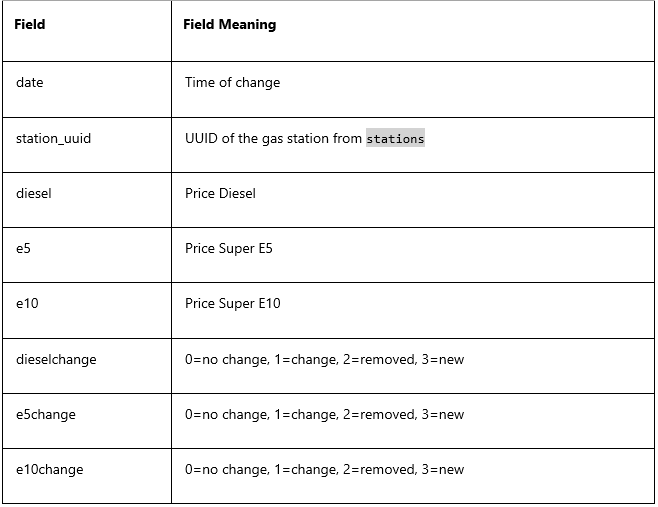


On the other hand, the directory "Gas stations" contains further files, which are exported daily into a directory stations/YEAR/MONTH/. Fields, which are in the head of these CSV files, are...

`uuid,name,brand,street,house_number,post_code,city,latitude,longitude`

with the following meaning:

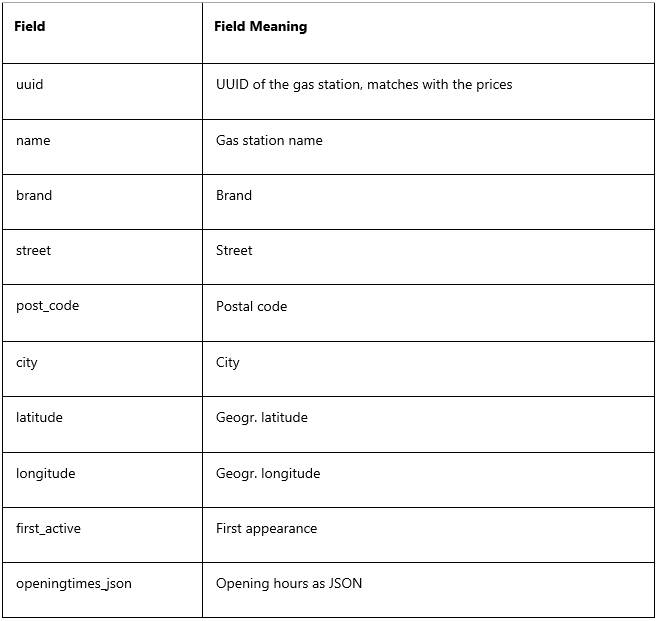


The individual CSV files can be matched using the `uuid` of the gas stations.



# Choice of Gas Station and competitors

The goal of the project is to provide a data-driven pricing for a specific gas station in Germany. To make sure that the pricing strategy can include prices of competitors the gas station should be located in a more urban region, in our case in the region of Karlsruhe. We decided to choose a gas station at the Durlach Center next to the highway A5. This gas station will be called REAL in the following analysis. 
Because fuel is a homogenous consumable good with a competetiv market it is important to include the competitors in the vicinity. The following determines all competitors in the radius of 1.5 km based on the gps-data.

In [ ]:
from math import radians, cos, sin, asin, sqrt
import numpy as np
import pandas as pd

#Function for the calcualtion of the distance between two gps points Source: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

%cd /content/drive/MyDrive/DataDeepDivers/tankerkoenig-data/stations/2021/01
path = '2021-01-01-stations.csv' 
stations = pd.read_csv(path) 

stations['city'] = stations['city'].str.lower() #data set consists of different writing styles for the city column--> has to be unified

stationsKA = stations[stations['city'] == "karlsruhe"] #subset of all gas stations in Karlsruhe
stationsKA = pd.DataFrame(data=stationsKA)

real = "51d4b715-a095-1aa0-e100-80009459e03a" #Uuid of the used gas station, will be called REAL in the following analysis

radius = 1.5 #Defintion of the radius, that defines a gas station as relevant for competitor analysis
n = 0
uuid_close = []

#Define GPS-Coordinates of REAL
id_real = np.where(stations["uuid"]==real)
long_real = stations.loc[id_real, "longitude"]
lat_real = stations.loc[id_real, "latitude"]

#Loop through all stations and check if they are within the defined radius
for i in range(len(stations)):  
  if(haversine(long_real, lat_real,stations.loc[i, "longitude"],stations.loc[i,'latitude'])<=radius):
    n = n + 1
    uuid_close.append(stations.loc[i, "uuid"])
    #print(stations.loc[i, "name"]+" - "+stations.loc[i, "uuid"]+" - "+stations.loc[i, "street"])

n = n - 1 #Used gas stations does not count as competitor
print('Number of competitors in a radius of '+str(radius)+' km: '+str(n))
pat = '|'.join(uuid_close)

i =0

#Make a subset with all relevant gas stations
for i in range(len(uuid_close)):
    stations_close = stations[stations['uuid'].str.contains(pat)]

stations_close.sample(len(stations_close))



/content/drive/MyDrive/DataDeepDivers/tankerkoenig-data/stations/2021/01
Number of competitors in a radius of 1.5 km: 5


,uuid,name,brand,street,house_number,post_code,city,latitude,longitude,first_active,openingtimes_json
6298,51d4b715-a095-1aa0-e100-80009459e03a,"Supermarkt-Tankstelle am real,- Markt KARLSRUH...","Supermarkt-Tankstelle am real,- Markt",DURLACHER ALLEE 111,NaN,76137,karlsruhe,49.004379,8.444545,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":59,""period..."
15484,fd606c1d-2f43-47df-8934-d1ea98871767,TOTAL Karlsruhe,TOTAL,Durlacher Allee 102,NaN,76137,karlsruhe,49.004658,8.438732,2018-12-03 23:30:10+01,"{""openingTimes"":[{""applicable_days"":31,""period..."
14659,5cb08765-da25-4bee-a118-a5710cb9aae5,Wolfartsweierer Straße,BFT,Wolfartsweierer Str.,46,76137,karlsruhe,48.999420,8.428337,2016-08-18 00:00:01+02,{}
13425,bf9d3a1f-c8a0-4ec3-93ed-018900da43c1,KARLSRUHE - KILLISFELDSTRASSE 44,Agip,Killisfeldstrasse,44,76227,karlsruhe,48.996460,8.454720,2014-03-20 00:00:01+01,"{""openingTimes"":[{""applicable_days"":15,""period..."
1843,51d4b432-a095-1aa0-e100-80009459e03a,JET KARLSRUHE KILLISFELDSTR. 32,JET,KILLISFELDSTR. 32,NaN,76227,karlsruhe,48.997040,8.456450,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":27,""period..."
10786,0d206f86-308b-43ae-a157-b7e625bdf61b,Aral Tankstelle,ARAL,Haid-und-Neu-Straße,60,76131,karlsruhe,49.015210,8.435365,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":103,""perio..."


In the next step we want the data for our gas station as well as for the gas station in the vicinity. For that we define a start and an end date of our analysis. Based on the available data we used 01.07.2017 as start date and 31.03.2021 as end date. 
Reading the prcing data is done by a loop that iterates through the years and months, which are respresent as folders in the data structure of tankerkönig. Per Month every csv-file, containing the prices of all gas stations per day, is readed. After the read of every file the prices for our used gas stations are seperated by subsetting and assigning to a dataframe. In the end we will recieve a csv-file with the data of our gas station and its competitors with all pricing information, that can be read in again in further analysis steps. This subshell runs approx. 40 min.


**Visualization of the Gas Stations in Karlsruhe**

gfesagseg


In [ ]:
import os, zipfile
import matplotlib.pyplot as plt
!pip install geopandas
import geopandas as gpd

%cd /content/drive/MyDrive/DataDeepDivers
%mkdir geo-data/
%cd geo-data/

#If not available download geo-data
if not os.path.isfile('plz-gebiete.shp.zip'):
  !wget https://www.suche-postleitzahl.org/download_files/public/plz-gebiete.shp.zip #Error 403

#Extract data from downloaded zip-file
cwd = os.getcwd()
zip_ref = zipfile.ZipFile('plz-gebiete.shp.zip') # create zipfile object
zip_ref.extractall(cwd) # extract file to dir
zip_ref.close()
!ls

#Read shape-file and create a Dataframe with geopandas for all PLZ-Areas in Germany
plz_path = 'plz-gebiete.shp'
shape_germany_df = gpd.read_file(plz_path, dtype={"plz": str})

#Combine the Dataframes stations and shapes
stations['plz'] = stations['post_code']
shape_germany_df = pd.merge(left=shape_germany_df, right=stations,on="plz",how="inner")

#Get GPS-Data of REAL
long_real = stations.loc[id_real, "longitude"]
lat_real = stations.loc[id_real, "latitude"]

#Subset of shapes and stations for Karlsruhe and initialise Plot
karlsruhe_df = shape_germany_df.query('city == "karlsruhe"')
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [10,10]

#Loop through every station in Karlsruhe
for long, lat in zip(stationsKA["longitude"], stationsKA["latitude"]):

#Blue Point for every Gas Station in Karlsruhe
  color = "blue" 
  ax.plot(
      long,
      lat,
      marker = "H",
      c=color,
      alpha=0.5,
      markersize=10)

#Loop through every station that is close to Real
for long, lat in zip(stations_close["longitude"], stations_close["latitude"]):

#Red Point for every Gas Station in the closer difinity of REAL
  color = "red"
  ax.plot(
      long,
      lat,
      marker = "o",
      c=color,
      alpha=1,
      markersize=10)

ax.text(
    long_real,
    lat_real + 0.05,
    "REAL Gas Station")

#Black rectangle for the REAL Gas Station
ax.plot(
    long_real,
    lat_real,
    marker = "D",
    c="black",
    alpha=1,
    markersize=12)

#Plot the map
mplleaflet.display(fig=fig)



/content/drive/MyDrive/DataDeepDivers
mkdir: cannot create directory ‘geo-data/’: File exists
/content/drive/MyDrive/DataDeepDivers/geo-data
plz-gebiete.dbf  plz-gebiete.shp      plz-gebiete.shx
plz-gebiete.prj  plz-gebiete.shp.zip


In [ ]:
import os
import csv
import pandas as pd
import numpy as np
import glob
from datetime import timedelta, date

%cd /content/drive/My Drive/DataDeepDivers/tankerkoenig-data/prices

#Defintion of Dates
start_date = date(2014, 7, 1)
end_date = date(2021, 3, 31)

#Start parameters for loop
year = start_date.year
month = start_date.month

#Array of all relevant gas stations
uuid_selected = stations_close['uuid']
pat = '|'.join(uuid_selected)

while year <= end_date.year: #Outer-Loop to iterate the years from start year until end year
  if year == start_date.year: #Exception for start year, if start month isn`t january
    month = start_date.month
  else:
    month = 1
  %cd /content/drive/My Drive/DataDeepDivers/tankerkoenig-data/prices
  os.chdir(str(year)) #Change directory to year  
  print(year) #Console-Output to see the progress
  while int(month) <= 12: #Inner-Loop to iterate the months
    print(month) #Console-Output to see the progress
    if year == end_date.year: #Exception for the end year, if end month isn`t december
      if month == end_date.month:
        break
    if month <10: #For the loop we need the months as data type integer, but the directorys in data structure are always 2-digits so we have to add a "0" for january to september
      month = "0"+str(month)
      print(month)      
    os.chdir(str(month)) #Change directory to month       
    path = os.getcwd()
    csv_files = glob.glob(os.path.join(path, "*.csv")) #Merge all csv files in the folder
    for file in csv_files: #Loop through the csv files
      add = pd.read_csv(file) #read each file
      add = add[add['station_uuid'].str.contains(pat)] #subset of newly readed file with the relevant gas stations
      if "df" in globals(): #add subset to dataframe if dataframe already exsists 
        df = df.append(add)
      else: 
        df = add
      del add      
    month = int(month) #re-transform month to integer
    month += 1 #go to next month
    os.chdir("..")
  month = 1 #after a whole year is done, set month back to january
  year += 1 #go to next year

df.info()
%cd /content/drive/My Drive/DataDeepDivers/tankerkoenig-data/prices
df.to_csv('prices_stations_close_'+str(radius)+'.csv', index=False) #write dataframe to csv if whole process is done

# Pre-Processing

# Pricing
The price is focusing on the oil price that the customer is paying to the gas station. Therefore, the price of the choosen gas station is compared to their competitors. The actual price and the effects of pricing strategies like increasing or decreasing the price are compared, based on the customer inventory.


# Impact of large-scaled Events

From an economic perspective, demand influences price. The demand increases if a lot of people visit a city because they attend an event. For Karlsruhe the project team noted the following events as potential impact for the gas price because of high demand:

*   Football games of the Karlsruher Sport-Club (KSC)
*   Das Fest - A popular Music festival
*   offerta - A consumer fair
*   Schlosslichtspiele - An event in the city of Karlsruhe

In the following data for these events is collected and created as well as weighted. Escpailay the data for football games has to be weighted because not every game attracts the same amount of people. 
Due to the covid-19 pandamic this analysis will include data from July 2017 until February 2020. The goal is to find out whether these events impact the price of the gas stations. 


## **Data for Karlsruher Sport-Club**

The data can be found on footystats.org or in the github repository. The data contains all league games of the KSC as well as all other games in the season. 
Cup games will be ignored because there were only a few amount of games that are relevant. For this analysis we only consider the away fans, because only the away fans have a longer trip to the stadium.

In the first step the KSC games will be filtered. We will have a look on Home and Away games because in both kind of games a large group of people will travel from or to Karlsruhe. In the next step the games will be classified into different categories, because not every game attracteds the same amount of people.

In [ ]:
%cd /content/drive/My Drive/DataDeepDivers/other

#Read in data of leagues and extract the KSC games
ksc1718 = pd.read_csv("germany-3-liga-matches-2017-to-2018-stats.csv")
ksc1718 = ksc1718[["date_GMT","Game Week","home_team_name","away_team_name","attendance","stadium_name"]]
ksc1718 = ksc1718[(ksc1718['home_team_name'] == "Karlsruher SC") |(ksc1718['away_team_name'] == "Karlsruher SC")]

ksc1819 = pd.read_csv("germany-3-liga-matches-2018-to-2019-stats.csv")
ksc1819 = ksc1819[["date_GMT","Game Week","home_team_name","away_team_name","attendance","stadium_name"]]
ksc1819 = ksc1819[(ksc1819['home_team_name'] == "Karlsruher SC") |(ksc1819['away_team_name'] == "Karlsruher SC")]

ksc1920 = pd.read_csv("germany-2-bundesliga-matches-2019-to-2020-stats.csv")
ksc1920 = ksc1920[["date_GMT","Game Week","home_team_name","away_team_name","attendance","stadium_name"]]
ksc1920 = ksc1920[(ksc1920['home_team_name'] == "Karlsruher SC") |(ksc1920['away_team_name'] == "Karlsruher SC")]

#Combine all season into one dataframe
ksc = ksc1718
ksc = ksc.append(ksc1819, ignore_index=True)
ksc = ksc.append(ksc1920, ignore_index=True)


ksc["date"] = ksc["date_GMT"].astype('datetime64[ns]') #Convert date to a date-data-type
ksc["attendance"] = ksc["attendance"].astype('int32')
ksc['event'] = ksc['home_team_name'] + " - " + ksc['away_team_name']
ksc["attendance_overall"] = ksc["attendance"]

#Model for away games: In Germany per Game there are round about 10% fans of the away team. If KSC has a away game 10% of the overvall attendance from Karlsruhe and is relevant for the analysis
for i in range(len(ksc)):
  if 'Karlsruher SC' in ksc.loc[i,'away_team_name']:
    ksc.loc[i,'attendance'] = ksc.loc[i,'attendance'] * 0.1

ksc["attendance"] = ksc["attendance"].astype('int32')
kscshort = ksc[['date','event','attendance']]

kscshort.sample(5)

/content/drive/My Drive/DataDeepDivers/other


,date,event,attendance
79,2019-08-25 11:30:00,Karlsruher SC - Hamburger SV,15000
84,2019-10-04 16:30:00,Darmstadt 98 - Karlsruher SC,1485
89,2019-11-24 12:30:00,Stuttgart - Karlsruher SC,5748
1,2017-07-28 17:00:00,Unterhaching - Karlsruher SC,500
70,2019-04-15 17:00:00,Würzburger Kickers - Karlsruher SC,785


## **Data for "Das Fest", "Offerta" and "Schlosslichtspiele"**

For these events there aren`t any predefined data sources (csv, ...) available so we will create this data frames manually basend on information from different sources.

In [ ]:
dataOfferta = {'date':       ['28.10.2017','29.10.2017','30.10.2017','31.10.2017','01.11.2017','02.11.2017','03.11.2017','04.11.2017','05.11.2017','27.10.2018','28.10.2018','29.10.2018','30.10.2018','31.10.2018','01.11.2018','02.11.2018','03.11.2018',
                              '04.11.2018','26.10.2019','27.10.2019','28.10.2019','29.10.2019','30.10.2019','31.10.2019','01.11.2019','02.11.2019','03.11.2019'],
               'event':      ['Offerta','Offerta','Offerta','Offerta','Offerta','Offerta','Offerta','Offerta','Offerta','Offerta','Offerta','Offerta','Offerta','Offerta','Offerta','Offerta','Offerta','Offerta','Offerta','Offerta','Offerta','Offerta',
                              'Offerta','Offerta','Offerta','Offerta','Offerta'],
               'attendance': ['15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555','15555',]        
              } #Source: Various local newspapers

offerta = pd.DataFrame(dataOfferta, columns=['date','event','attendance'])
offerta["date"] = offerta["date"].astype('datetime64[ns]')
offerta["attendance"] = offerta["attendance"].astype('int32')

#print(offerta)
#offerta.sample(10)

In [ ]:
dataFest = {'date':       ['24.07.2017','25.07.2017','26.07.2017','20.07.2018','21.07.2018','22.07.2018','19.07.2019','20.07.2019','21.07.2019'],
               'event':      ['Das Fest','Das Fest','Das Fest','Das Fest','Das Fest','Das Fest','Das Fest','Das Fest','Das Fest'],
               'attendance': ['65000','70000','85000','65000','70000','85000','65000','70000','85000']        
              } #Source: Various local newspapers

fest = pd.DataFrame(dataFest, columns=['date','event','attendance'])
fest["date"] = fest["date"].astype('datetime64[ns]')
fest["attendance"] = fest["attendance"].astype('int32')

#print(fest)
#fest.info()

In [ ]:
dataSchlosslichtspiele = {'date': ['03.08.2017','04.08.2017','05.08.2017','06.08.2017','07.08.2017','08.08.2017','09.08.2017','10.08.2017','11.08.2017','12.08.2017','13.08.2017','14.08.2017','15.08.2017','16.08.2017','17.08.2017','18.08.2017','19.08.2017','20.08.2017',
                                   '21.08.2017','22.08.2017','23.08.2017','24.08.2017','25.08.2017','26.08.2017','27.08.2017','28.08.2017','29.08.2017','30.08.2017','31.08.2017','01.09.2017','02.09.2017','03.09.2017','04.09.2017','05.09.2017','06.09.2017','07.09.2017',
                                   '08.09.2017','09.09.2017','10.09.2017','28.07.2018','29.07.2018','30.07.2018','31.07.2018','01.08.2018','02.08.2018','03.08.2018','04.08.2018','05.08.2018','06.08.2018','07.08.2018','08.08.2018','09.08.2018','10.08.2018','11.08.2018',
                                   '12.08.2018','13.08.2018','14.08.2018','15.08.2018','16.08.2018','17.08.2018','18.08.2018','19.08.2018','20.08.2018','21.08.2018','22.08.2018','23.08.2018','24.08.2018','25.08.2018','26.08.2018','27.08.2018','28.08.2018','29.08.2018',
                                   '30.08.2018','31.08.2018','01.09.2018','02.09.2018','03.09.2018','04.09.2018','05.09.2018','06.09.2018','07.09.2018','08.09.2018','09.09.2018','08.08.2019','09.08.2019','10.08.2019','11.08.2019','12.08.2019','13.08.2019','14.08.2019',
                                   '15.08.2019','16.08.2019','17.08.2019','18.08.2019','19.08.2019','20.08.2019','21.08.2019','22.08.2019','23.08.2019','24.08.2019','25.08.2019','26.08.2019','27.08.2019','28.08.2019','29.08.2019','30.08.2019','31.08.2019','01.09.2019',
                                   '02.09.2019','03.09.2019','04.09.2019','05.09.2019','06.09.2019','07.09.2019','08.09.2019','09.09.2019','10.09.2019','11.09.2019','12.09.2019','13.09.2019','14.09.2019','15.09.2019'],
               'event':      ['Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele',
                              'Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele',
                              'Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele',
                              'Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele',
                              'Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele',
                              'Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele',
                              'Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele',
                              'Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele',
                              'Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele',
                              'Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele',
                              'Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele',
                              'Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele','Schlosslichtspiele',
                              'Schlosslichtspiele','Schlosslichtspiele'],
               'attendance': ['6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487','6487',
                              '6487','6487','6487','6487','6487','6487','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139',
                              '8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8139','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102',
                              '8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102','8102']        
              } #Source: https://bnn.de/karlsruhe/karlsruher-schlosslichtspiele-mit-mehr-als-310-000-besuchern#:~:text=Karlsruher%20Schlosslichtspiele%20mit%20mehr%20als%20310.000%20Besuchern 

schlosslichtspiele = pd.DataFrame(dataSchlosslichtspiele, columns=['date','event','attendance'])
schlosslichtspiele["date"] = schlosslichtspiele["date"].astype('datetime64[ns]')
schlosslichtspiele["attendance"] = schlosslichtspiele["attendance"].astype('int32')

#print(Schlosslichtspiele)
#Schlosslichtspiele.info()

## **Analysis large-scaled events**

xy

                   date                               event  attendance
0   2017-07-21 18:30:00           Karlsruher SC - Osnabrück       14837
3   2017-08-05 12:00:00     Karlsruher SC - Wehen Wiesbaden        9646
5   2017-08-26 12:00:00       Karlsruher SC - Hallescher FC        9580
7   2017-09-16 12:00:00  Karlsruher SC - Sportfreunde Lotte        8438
9   2017-09-24 12:00:00     Karlsruher SC - Rot-Weiß Erfurt        9709
..                  ...                                 ...         ...
263 2019-11-09 00:00:00                  Schlosslichtspiele        8102
264 2019-12-09 00:00:00                  Schlosslichtspiele        8102
265 2019-09-13 00:00:00                  Schlosslichtspiele        8102
266 2019-09-14 00:00:00                  Schlosslichtspiele        8102
267 2019-09-15 00:00:00                  Schlosslichtspiele        8102

[217 rows x 3 columns]


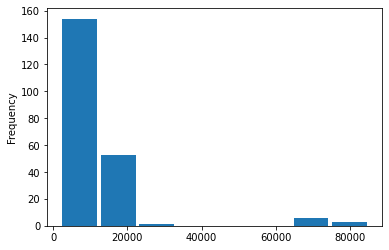

In [ ]:
#Combine all kind of events in one dataframe
events = kscshort
events = events.append(offerta,ignore_index=True)
events = events.append(fest,ignore_index=True)
events = events.append(schlosslichtspiele,ignore_index=True)

events = events[events['attendance'] >= 2000]


print(events)

plotdata = events['attendance']

plotdata.plot.hist(bins=8, rwidth=0.9)

events.loc[events['attendance']>=20000, 'class'] = 1
events.loc[(events['attendance']>=10000) & (events['attendance']<20000), 'class'] = 2
events.loc[events['attendance']<10000, 'class'] = 3

# Impact of weather

The next aspect we want to analyse is the impact of weather. The Assumption is that more people make trips if the weather is good which will lead to an increase in the price for fuel because of higher demand. In the following we want to proof if this assumption is correct and if so if its worth it to include weather data in the pricing model. 

The data is provided by Deutscher Wetterdienst (DWD) which runs hundreds of weather stations in Germany. If you have a look at the stations list (https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/historical/zehn_min_tu_Beschreibung_Stationen.txt) you find a station in Karlsurhe which is located 5.3 km away from REAL. Unfortunaly this weather station was shut down in 2008 so there isn't data available for our analysis time periode. 
For that reason we choose a weather station in Rheinstetten (9.5 km away of REAL). 

The goal is to generate a data frame with each day in the analysis time periode and a metric from 0 to 1 that indicated good weather in the morning, midday and evening. 1 stands for the best possible weather with warm tempatures and no rain, 0 stands for Rain and low tempartures. 
For this we download the data as zip-files from DWD. For rain and air temperature we need '10_minutes_hist_10_19' which contains a 10 minutes measurements from 2010 to 2019. Further we need '10_minutes_akt' for the measurments since 2020 to 2021. Because this files are always from the day bevor today until 500 days in past, a download form the official side will lead to a lack of data because the submission date of this analysis. For that we uploaded this files in the github repo. 

In [ ]:
import zipfile, os

#Download and Unzip Precipitation and Temperature data
%cd /content/drive/MyDrive/DataDeepDivers
!mkdir weather
%cd weather

#Rain data for Rheinstetten 2010-2019
if not os.path.isfile('10minutenwerte_nieder_04177_20100101_20191231_hist.zip'):
  !wget https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/precipitation/historical/10minutenwerte_nieder_04177_20100101_20191231_hist.zip

#Rain data for Rheinstetten December 2019 - June 2021
if not os.path.isfile('10minutenwerte_nieder_04177_akt.zip'):
  !wget https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/precipitation/recent/10minutenwerte_nieder_04177_akt.zip ##ERSETZEN MIT GITHUB LINK

#Air temperature data for Rheinstetten 2010-2019
if not os.path.isfile('10minutenwerte_TU_04177_20100101_20191231_hist.zip'):
  !wget https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/historical/10minutenwerte_TU_04177_20100101_20191231_hist.zip

#Air temperature for Rheinstetten December 2019 - June 2021
if not os.path.isfile('10minutenwerte_TU_04177_akt.zip'):
  !wget https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/recent/10minutenwerte_TU_04177_akt.zip ##ERSETZEN MIT GITHUB LINK


#Loop through folder and extract all zip-files (Source: https://stackoverflow.com/questions/31346790/unzip-all-zipped-files-in-a-folder-to-that-same-folder-using-python-2-7-5)
cwd = os.getcwd()
extension = ".zip"
for item in os.listdir(cwd): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = os.path.abspath(item) # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(cwd) # extract file to dir
        zip_ref.close() # close file
!ls

After downloading and extracting the zip-files the feature engineering starts. First the data is read in from every file and subseted to relevant time periode (01.07.2014 - 31.03.2017). Next all dataframes are merged togehter so we only have one data frame with the 10 minutes measurements of rain and temperture. Next 'morning' is defined from 7 am to 12 am, 'midday' is defined from 12 am to 5 pm and 'evening' is defined from 5 pm to 9 pm. Everything outside of this range is not relevant because it is not the typical time for trips and excursions. After that, we evaluate if the weather is good in the morning, midday and evening and resample everything as the mean per day. In the last steps we make sure that the values for good weather are really a value between 0 and 1 and reduce the dataframe to only the relevant values.

In [ ]:
%cd /content/drive/MyDrive/DataDeepDivers/weather/

from datetime import datetime, time
import pandas as pd
import numpy as np
import os


#Read in all data from the extracted txt-files
sub_rain = 'produkt_zehn_min_rr_20191201_'
sub_air = 'produkt_zehn_min_tu_20191201_'

###
### Nochmal Zeitrechnisch mit Download nacharbeiten, da Akt immer 500 Tage zurückliegt und dies mit der Korrektur knapp wird
###

file_rain = [s for s in  os.listdir(os.getcwd()) if sub_rain in s]
file_air = [s for s in  os.listdir(os.getcwd()) if sub_air in s]

rain_10_19 = pd.read_csv('produkt_zehn_min_rr_20100101_20191231_04177.txt', sep=";")
rain_10_19 = rain_10_19[(rain_10_19['MESS_DATUM']>=201407010000)]
rain_10_19['MESS_DATUM'] = pd.to_datetime(rain_10_19['MESS_DATUM'], format='%Y%m%d%H%M')

rain_20_21 = pd.read_csv(file_rain[0], sep=";")
rain_20_21 = rain_20_21[(rain_20_21['MESS_DATUM']>=202001010000)&(rain_20_21['MESS_DATUM']<=202103312350)]
rain_20_21['MESS_DATUM'] = pd.to_datetime(rain_20_21['MESS_DATUM'], format='%Y%m%d%H%M')

air_10_19 = pd.read_csv('produkt_zehn_min_tu_20100101_20191231_04177.txt', sep=";")
air_10_19 = air_10_19[(air_10_19['MESS_DATUM']>=201407010000)]
air_10_19['MESS_DATUM'] = pd.to_datetime(air_10_19['MESS_DATUM'], format='%Y%m%d%H%M')

air_20_21 = pd.read_csv(file_air[0], sep=";")
air_20_21 = air_20_21[(air_20_21['MESS_DATUM']>=202001010000)&(air_20_21['MESS_DATUM']<=202103312350)]
air_20_21['MESS_DATUM'] = pd.to_datetime(air_20_21['MESS_DATUM'], format='%Y%m%d%H%M')

#Merge all dataframes together
rain = rain_10_19.append(rain_20_21)
air = air_10_19.append(air_20_21)
rain = rain.drop(columns=['eor','  QN',])
air = air.drop(columns=['eor','  QN','STATIONS_ID'])

del air_10_19, air_20_21, rain_10_19, rain_20_21

weather = pd.merge(left=rain, right=air, on='MESS_DATUM',how='inner')

weather['time'] = [d.time() for d in weather['MESS_DATUM']]
weather['date'] = [d.date() for d in weather['MESS_DATUM']]

#Pre-Work to decide if weather is good
weather['morning'] = 0
weather['midday'] = 0
weather['evening'] = 0
weather['good_weather_morning'] = 0
weather['good_weather_midday'] = 0
weather['good_weather_evening'] = 0

weather.loc[(weather['time'] >= time(7,00)) & (weather['time'] < time(12,00)), 'morning'] = 1
weather.loc[(weather['time'] >= time(12,00)) & (weather['time'] < time(17,00)), 'midday'] = 1
weather.loc[(weather['time'] >= time(17,00)) & (weather['time'] <= time(21,00)), 'evening'] = 1

#Specify if Weather counts as "good". Good means no rain (RWS_10 = 0) and Warm temperatures (TT_10 >15)
weather.loc[(weather['morning']==1) & (weather['RWS_10'] <= 0) & (weather['TT_10'] >=10.0), 'good_weather_morning'] = 1
weather.loc[(weather['midday']==1) & (weather['RWS_10'] <= 0) & (weather['TT_10'] >=15.0), 'good_weather_midday'] = 1
weather.loc[(weather['evening']==1) & (weather['RWS_10'] <= 0) & (weather['TT_10'] >=15.0), 'good_weather_evening'] = 1

#Resample for daily averages
weather.index = weather['MESS_DATUM']
weather = weather.drop('MESS_DATUM', axis=1)
w_davg = weather.resample('D').mean()

#Each day consits of 144 measurments (00:00 to 23:50 in 10 minutes steps). 'Morning' and 'Midday' consits of 30, 'Evening' consists of 25. By multiplying this share we get a more usefull values in 'good_weather'. 
#A Value of 1 in 'good_weather' means that every of the 30 or 25 measurements was labeled as good.
w_davg['good_weather_morning'] = w_davg['good_weather_morning']/(30/144)
w_davg['good_weather_midday'] = w_davg['good_weather_midday']/(30/144)
w_davg['good_weather_evening'] = w_davg['good_weather_evening']/(25/144)

#Reduce dataframe to relevant measurements
w_davg_short = w_davg.drop(columns=['STATIONS_ID','RWS_DAU_10','RWS_IND_10','PP_10','TM5_10','RF_10','TD_10','morning','midday','evening','TT_10','RWS_10'])

#w_davg_short.describe()
w_davg_short.sample(10)

# Impact of Oil 

...

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!ls

additionalDataSourcesTest   oilprice-data      TobisSpielwiese.ipynb
BigDataAnalytics_DataDepot  tankerkoenig-data  wkn_COM062_historic.csv
Oilprice_BrentCrude.csv     titanic.csv


In [ ]:
! git clone https://github.com/imiolczy/additionalDataSourcesTest

In [ ]:
oil_courses = pd.read_csv ("/content/drive/MyDrive/DataDeepDivers/additionalDataSourcesTest/additional Data Sets/oil.csv", sep= ';')

In [ ]:
oil_courses

,Datum,Erster,Hoch,Tief,Schlusskurs,Stuecke,Volumen
0,2021-04-26,"65,48","66,04","64,59","65,83",NaN,NaN
1,2021-04-23,"65,83","66,30","65,14","65,93",NaN,NaN
2,2021-04-22,"65,14","65,60","64,57","65,25",NaN,NaN
3,2021-04-21,"66,39","66,52","64,93","65,36",NaN,NaN
4,2021-04-20,"67,76","68,07","65,53","66,40",NaN,NaN
...,...,...,...,...,...,...,...
1757,2014-06-13,"112,785","114,06","112,005","112,36",NaN,NaN
1758,2014-06-12,"109,485","112,725","109,485","112,67",NaN,NaN
1759,2014-06-11,"108,92","109,575","108,905","109,495",NaN,NaN
1760,2014-06-10,"109,145","109,495","108,44","108,865",NaN,NaN


#Product
The analysis is based on the product oil. The product oil is divided into their subcategories and these are compared to each other.


#Place
The effect of the factor place is analyzed based on advantages or disadvantages for the choosen gas station. These advantages or disadvantages are measured with the price or the customer inventory of the competitors.

#Promotion
Due to missing data, an analysis of the effects of promotion will not be further analyzed.

# Conclusion 